# Pipeline to manage anomalies processing

Before using any dataset, it is necessary to clean the data to obtain a clear, formatted, and complete dataset. This tedious step is the first step in data analysis.

In this notebook, there are building blocks (functions) that can be used later to perform the identified preprocessing steps.

- Remove missing values
- Remove duplicates
- Remove special characters
- Convert numbers to letters
- Identify the language of the review and translate it if necessary
- Correct spelling errors

In [25]:
import polars as pl
import re
from num2words import num2words
import langid
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from deep_translator import GoogleTranslator
from spellchecker import SpellChecker

## Remove missing values

In [26]:
def clean_missing_values(df: pl.DataFrame, column_name: str) -> pl.DataFrame:
    """
    Remove rows from a DataFrame where the specified column has missing values,
    and return the cleaned DataFrame.
    
    Args:
        df (pl.DataFrame): The DataFrame to clean.
        column_name (str): Column to check for missing values.
        
    Returns:
        pl.DataFrame: Cleaned DataFrame.
    """
    # Drop rows where the specified column is null
    df_clean = df.drop_nulls(subset=[column_name])
    
    return df_clean

In [27]:
# Example of use
df = pl.read_csv("../data/processed/all_reviews.csv")
df_clean_missing_values = clean_missing_values(df, "review")
print(df.shape)
print(df_clean_missing_values.shape)

(3363667, 5)
(2835129, 5)


## Remove duplicates

In [28]:
def remove_duplicates(df: pl.DataFrame, subset_columns: list) -> pl.DataFrame:
    """
    Remove duplicate rows from a DataFrame based on specified columns,
    and return the cleaned DataFrame.
    
    Args:
        df (pl.DataFrame): The DataFrame to clean.
        subset_columns (list): List of columns to consider for duplicates.
        
    Returns:
        pl.DataFrame: DataFrame with duplicates removed.
    """
    # Drop duplicates based on the subset of columns
    df_clean = df.unique(subset=subset_columns)
    
    return df_clean

In [29]:
# Example of use
df_clean_duplicates = remove_duplicates(df_clean_missing_values, "review")
print(df_clean_missing_values.shape)
print(df_clean_duplicates.shape)

(2835129, 5)
(2811720, 5)


## Remove spacial characters

In [30]:
def remove_special_characters(df: pl.DataFrame, column_name: str, keep: str = "") -> pl.DataFrame:
    """
    Remove special characters from a specified text column using regex.

    Args:
        df (pl.DataFrame): Input Polars DataFrame.
        column_name (str): Name of the text column to clean.
        keep (str): Optional string of characters to preserve (e.g., ".," to keep dots and commas).

    Returns:
        pl.DataFrame: New DataFrame with cleaned text in the specified column.
    """
    # Build regex dynamically: allow alphanumeric, space, underscore, and chosen extra characters
    pattern = rf"[^\w\s{re.escape(keep)}]"

    def clean_text(text: str) -> str:
        if not isinstance(text, str) or not text.strip():
            return text  # ignore empty or non-string
        return re.sub(pattern, "", text)

    df_cleaned = df.with_columns(
        pl.col(column_name).map_elements(clean_text).alias(column_name)
    )

    return df_cleaned

In [31]:
# Example of use
df_no_special_character = remove_special_characters(df_clean_duplicates, "review", ".,!?")
print(df_no_special_character.head())

shape: (5, 5)
┌───────────┬────────────────────────────┬───────────────────────────┬─────────────┬───────────────┐
│ id_review ┆ review                     ┆ original_dataset          ┆ original_id ┆ service_type  │
│ ---       ┆ ---                        ┆ ---                       ┆ ---         ┆ ---           │
│ i64       ┆ str                        ┆ str                       ┆ i64         ┆ str           │
╞═══════════╪════════════════════════════╪═══════════════════════════╪═════════════╪═══════════════╡
│ 3052444   ┆ No Negative  Gourmet       ┆ data_european_hotel_revie ┆ 204516      ┆ accommodation │
│           ┆ breakfast                  ┆ ws                        ┆             ┆               │
│ 934508    ┆ We stayed here one night   ┆ data_tripadvisor_hotel_re ┆ 133456549   ┆ accommodation │
│           ┆ on a …                     ┆ views                     ┆             ┆               │
│ 1518996   ┆ I have stayed before,      ┆ data_booking              ┆ 503844

## Convert numbers to letters

In [32]:
def numbers_to_words(df: pl.DataFrame, column_name: str) -> pl.DataFrame:
    """
    Convert all numbers in a text column into words using num2words.

    Args:
        df (pl.DataFrame): Input DataFrame.
        column_name (str): Name of the text column to process.
        lang (str): Language code (e.g., 'en' or 'fr').

    Returns:
        pl.DataFrame: New DataFrame with numbers replaced by words.
    """
    def convert_numbers(text: str) -> str:
        if not isinstance(text, str) or not text.strip():
            return text
        # Replace every number with its text version
        return re.sub(r'\b\d+\b', lambda m: num2words(int(m.group())), text)

    df_converted = df.with_columns(
        pl.col(column_name).map_elements(convert_numbers).alias(column_name)
    )

    return df_converted

In [33]:
# Example of use
df_without_number = numbers_to_words(df_no_special_character.head(100), "review")
print(df_without_number.head())

shape: (5, 5)
┌───────────┬────────────────────────────┬───────────────────────────┬─────────────┬───────────────┐
│ id_review ┆ review                     ┆ original_dataset          ┆ original_id ┆ service_type  │
│ ---       ┆ ---                        ┆ ---                       ┆ ---         ┆ ---           │
│ i64       ┆ str                        ┆ str                       ┆ i64         ┆ str           │
╞═══════════╪════════════════════════════╪═══════════════════════════╪═════════════╪═══════════════╡
│ 3052444   ┆ No Negative  Gourmet       ┆ data_european_hotel_revie ┆ 204516      ┆ accommodation │
│           ┆ breakfast                  ┆ ws                        ┆             ┆               │
│ 934508    ┆ We stayed here one night   ┆ data_tripadvisor_hotel_re ┆ 133456549   ┆ accommodation │
│           ┆ on a …                     ┆ views                     ┆             ┆               │
│ 1518996   ┆ I have stayed before,      ┆ data_booking              ┆ 503844

## Languages and translation

### Languages detection

In [34]:
def detect_language_parallel(df: pl.DataFrame, column_name: str, num_threads: int = 4) -> pl.DataFrame:
    """
    Detect the language of a text column in a Polars DataFrame using langid in parallel.

    Args:
        df (pl.DataFrame): Input DataFrame.
        column_name (str): Name of the text column to process.
        num_threads (int): Number of threads to use for parallel processing (default=4).

    Returns:
        pl.DataFrame: New DataFrame with an added column 'detected_lang' containing language codes.
    """
    def detect_lang(text: str) -> str:
        """Return the language code of a single text using langid."""
        if not isinstance(text, str) or not text.strip():
            return None
        lang, _ = langid.classify(text)
        return lang

    # Convert the Polars column to a Python list
    texts = df[column_name].to_list()

    # Parallel processing with ThreadPoolExecutor
    all_langs = []
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        for result in tqdm(executor.map(detect_lang, texts), total=len(texts), desc="Language detection"):
            all_langs.append(result)

    # Return new DataFrame with added column
    df_result = df.with_columns(pl.Series("detected_lang", all_langs))
    return df_result

In [35]:
# Example of use
df_new = detect_language_parallel(df.head(100), column_name="review", num_threads=4)
counts = df_new.group_by("detected_lang").agg(pl.len().alias("nb_texts")).sort("nb_texts", descending=True)
print(counts)

Language detection:  42%|████▏     | 42/100 [00:00<00:00, 401.20it/s]

Language detection: 100%|██████████| 100/100 [00:00<00:00, 341.08it/s]


shape: (4, 2)
┌───────────────┬──────────┐
│ detected_lang ┆ nb_texts │
│ ---           ┆ ---      │
│ str           ┆ u32      │
╞═══════════════╪══════════╡
│ en            ┆ 97       │
│ sv            ┆ 1        │
│ pl            ┆ 1        │
│ it            ┆ 1        │
└───────────────┴──────────┘


In [36]:
non_english_reviews = df_new.filter(pl.col("detected_lang") != "en")
print(non_english_reviews)

shape: (3, 6)
┌───────────┬────────────────────┬────────────────────┬─────────────┬──────────────┬───────────────┐
│ id_review ┆ review             ┆ original_dataset   ┆ original_id ┆ service_type ┆ detected_lang │
│ ---       ┆ ---                ┆ ---                ┆ ---         ┆ ---          ┆ ---           │
│ i64       ┆ str                ┆ str                ┆ i64         ┆ str          ┆ str           │
╞═══════════╪════════════════════╪════════════════════╪═════════════╪══════════════╪═══════════════╡
│ 61        ┆ Relaxing,          ┆ data_activities_re ┆ 62          ┆ leisure      ┆ it            │
│           ┆ Swimming,          ┆ views              ┆             ┆              ┆               │
│           ┆ vacationin…        ┆                    ┆             ┆              ┆               │
│ 77        ┆ Bingo   Space   TV ┆ data_activities_re ┆ 78          ┆ leisure      ┆ pl            │
│           ┆                    ┆ views              ┆             ┆        

### Translation in english

In [37]:
def translate_non_english_parallel(df: pl.DataFrame, column_name: str, detected_lang_col: str = "detected_lang", num_threads: int = 4) -> pl.DataFrame:
    """
    Translate texts in a Polars DataFrame column to English in parallel, only for texts detected in a language other than English.

    Args:
        df (pl.DataFrame): Input DataFrame.
        column_name (str): Name of the text column to translate.
        detected_lang_col (str): Name of the column containing detected language codes (default='detected_lang').
        num_threads (int): Number of threads to use for parallel translation (default=4).

    Returns:
        pl.DataFrame: New DataFrame with an added column 'translated_text' containing English translations.
                      Texts already in English are kept unchanged.
    """
    # Initialize the translator
    translator = GoogleTranslator(source='auto', target='en')

    def translate_one(text: str) -> str:
        """Translate a single text to English, return the text unchanged if empty or already in English."""
        if not isinstance(text, str) or not text.strip():
            return text
        try:
            return translator.translate(text)
        except Exception as e:
            return f"[ERROR: {e}]"

    # Prepare texts to translate
    texts_to_translate = []
    indices_to_translate = []
    for i, (text, lang) in enumerate(zip(df[column_name].to_list(), df[detected_lang_col].to_list())):
        if lang != 'en':
            texts_to_translate.append(text)
            indices_to_translate.append(i)

    # Parallel translation
    translated_texts = [None] * df.height
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        for idx, result in zip(indices_to_translate, tqdm(executor.map(translate_one, texts_to_translate), total=len(texts_to_translate), desc="Translating non-English")):
            translated_texts[idx] = result

    # Fill in English texts unchanged
    for i in range(df.height):
        if translated_texts[i] is None:
            translated_texts[i] = df[column_name][i]

    # Return new DataFrame with added column
    df_result = df.with_columns(pl.Series("translated_text", translated_texts))
    return df_result


In [38]:
from deep_translator import GoogleTranslator
import polars as pl
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

def translate_non_english_safe(df: pl.DataFrame,
                               column_name: str,
                               detected_lang_col: str = "detected_lang",
                               num_threads: int = 4) -> pl.DataFrame:
    """
    Translate only the reviews not in English and replace them directly.
    Reviews detected as English are left unchanged.
    """
    translator = GoogleTranslator(source='auto', target='en')

    def translate_one(text: str) -> str:
        if not isinstance(text, str) or not text.strip():
            return text
        try:
            return translator.translate(text)
        except Exception as e:
            return f"[ERROR: {e}]"

    # Collect indices and texts to translate
    indices_to_translate = []
    texts_to_translate = []

    for i, (text, lang) in enumerate(zip(df[column_name].to_list(), df[detected_lang_col].to_list())):
        if lang != 'en':
            indices_to_translate.append(i)
            texts_to_translate.append(text)

    # Prepare list to store results
    translated_texts = df[column_name].to_list()

    # Parallel translation
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        for idx, translation in zip(indices_to_translate, tqdm(executor.map(translate_one, texts_to_translate),
                                                               total=len(texts_to_translate),
                                                               desc="Translating non-English")):
            translated_texts[idx] = translation

    # Return new DataFrame with updated column
    return df.with_columns(pl.Series(column_name, translated_texts))


In [39]:
from deep_translator import GoogleTranslator
import polars as pl
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from typing import List

def translate_non_english_optimize(df: pl.DataFrame,
                                   column_name: str,
                                   detected_lang_col: str = "detected_lang",
                                   num_threads: int = 4,
                                   batch_size: int = 20) -> pl.DataFrame:
    """
    Translate texts in a Polars DataFrame column to English in parallel, only for texts detected in a language other than English.
    Uses batch processing to split work for threads (but each text is translated individually).
    """
    translator = GoogleTranslator(source='auto', target='en')

    # Prepare texts to translate and their indices
    texts_to_translate = []
    indices_to_translate = []
    for i, (text, lang) in enumerate(zip(df[column_name].to_list(), df[detected_lang_col].to_list())):
        if lang != 'en' and isinstance(text, str) and text.strip():
            texts_to_translate.append(text)
            indices_to_translate.append(i)

    if not texts_to_translate:
        return df.with_columns(pl.Series("translated_text", df[column_name]))

    # Split indices into batches for threading
    batches = [indices_to_translate[i:i+batch_size] for i in range(0, len(indices_to_translate), batch_size)]

    # Function to translate one text safely
    def translate_one(text: str) -> str:
        try:
            return translator.translate(text)
        except Exception as e:
            return f"[ERROR: {e}]"

    # Translate a batch of indices
    def translate_batch(batch_indices: List[int]) -> List[tuple[int, str]]:
        results = []
        for idx in batch_indices:
            text = df[column_name][idx]
            translated = translate_one(text)
            results.append((idx, translated))
        return results

    # Prepare translated_texts list
    translated_texts = [None] * df.height

    # Multi-thread batch translation
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        for batch_result in tqdm(executor.map(translate_batch, batches),
                                 total=len(batches),
                                 desc="Translating non-English"):
            for idx, translated in batch_result:
                translated_texts[idx] = translated

    # Fill in texts already in English
    for i in range(df.height):
        if translated_texts[i] is None:
            translated_texts[i] = df[column_name][i]

    return df.with_columns(pl.Series("translated_text", translated_texts))


In [40]:
## Celui qui fonctionne

from deep_translator import GoogleTranslator
import polars as pl
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

def translate_non_english_threadsafe(df: pl.DataFrame,
                                     column_name: str,
                                     detected_lang_col: str = "detected_lang",
                                     num_threads: int = 4) -> pl.DataFrame:
    """
    Thread-safe translation: one translator per thread.
    """
    def translate_one(text: str) -> str:
        if not isinstance(text, str) or not text.strip():
            return text
        try:
            translator = GoogleTranslator(source='auto', target='en')  # <— crée un traducteur local
            return translator.translate(text)
        except Exception as e:
            return f"[ERROR: {e}]"

    indices_to_translate = []
    texts_to_translate = []
    for i, (text, lang) in enumerate(zip(df[column_name].to_list(), df[detected_lang_col].to_list())):
        if lang != 'en':
            indices_to_translate.append(i)
            texts_to_translate.append(text)

    translated_texts = df[column_name].to_list()

    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        for idx, translation in zip(
            indices_to_translate,
            tqdm(executor.map(translate_one, texts_to_translate),
                 total=len(texts_to_translate),
                 desc="Translating non-English (thread-safe)")
        ):
            translated_texts[idx] = translation

    return df.with_columns(pl.Series(column_name, translated_texts))


In [41]:
df_new = df_clean_missing_values.head(1000)
df_new = detect_language_parallel(df_new, column_name="review", num_threads=4)

Language detection: 100%|██████████| 1000/1000 [00:02<00:00, 490.17it/s]


In [42]:
# Example of use 
df_translated = translate_non_english_safe(df_new, column_name="review", detected_lang_col="detected_lang", num_threads=4)
print(df_translated.filter(pl.col("detected_lang") != "en"))

Translating non-English:  99%|█████████▊| 66/67 [00:15<00:00,  4.25it/s]

shape: (67, 6)
┌───────────┬────────────────────┬────────────────────┬─────────────┬──────────────┬───────────────┐
│ id_review ┆ review             ┆ original_dataset   ┆ original_id ┆ service_type ┆ detected_lang │
│ ---       ┆ ---                ┆ ---                ┆ ---         ┆ ---          ┆ ---           │
│ i64       ┆ str                ┆ str                ┆ i64         ┆ str          ┆ str           │
╞═══════════╪════════════════════╪════════════════════╪═════════════╪══════════════╪═══════════════╡
│ 61        ┆ Sledding, tv,      ┆ data_activities_re ┆ 62          ┆ leisure      ┆ it            │
│           ┆ bonfire            ┆ views              ┆             ┆              ┆               │
│ 77        ┆ Sledding, tv,      ┆ data_activities_re ┆ 78          ┆ leisure      ┆ pl            │
│           ┆ bonfire            ┆ views              ┆             ┆              ┆               │
│ 97        ┆ Sledding, tv,      ┆ data_activities_re ┆ 98          ┆ leisur

In [43]:
# Example of use 
df_translated = translate_non_english_threadsafe(df_new, column_name="review", detected_lang_col="detected_lang", num_threads=4)
print(df_translated.filter(pl.col("detected_lang") != "en"))
translate_non_english_threadsafe

Translating non-English (thread-safe):  99%|█████████▊| 66/67 [00:16<00:00,  4.01it/s]

shape: (67, 6)
┌───────────┬────────────────────┬────────────────────┬─────────────┬──────────────┬───────────────┐
│ id_review ┆ review             ┆ original_dataset   ┆ original_id ┆ service_type ┆ detected_lang │
│ ---       ┆ ---                ┆ ---                ┆ ---         ┆ ---          ┆ ---           │
│ i64       ┆ str                ┆ str                ┆ i64         ┆ str          ┆ str           │
╞═══════════╪════════════════════╪════════════════════╪═════════════╪══════════════╪═══════════════╡
│ 61        ┆ Relaxing,          ┆ data_activities_re ┆ 62          ┆ leisure      ┆ it            │
│           ┆ Swimming,          ┆ views              ┆             ┆              ┆               │
│           ┆ vacationin…        ┆                    ┆             ┆              ┆               │
│ 77        ┆ Bingo   Space   TV ┆ data_activities_re ┆ 78          ┆ leisure      ┆ pl            │
│           ┆                    ┆ views              ┆             ┆       

<function __main__.translate_non_english_threadsafe(df: polars.dataframe.frame.DataFrame, column_name: str, detected_lang_col: str = 'detected_lang', num_threads: int = 4) -> polars.dataframe.frame.DataFrame>

In [44]:
review_row = df.filter(pl.col("id_review") == 109)

# Afficher le texte de la review
print(review_row["review"].to_list()[0])

golf, swimming, sex


In [45]:
# Example of use 
df_translated = translate_non_english_optimize(df_new, column_name="review", detected_lang_col="detected_lang", num_threads=4, batch_size=100)
print(df_translated.filter(pl.col("detected_lang") != "en"))

Translating non-English: 100%|██████████| 1/1 [01:05<00:00, 65.54s/it]

shape: (67, 7)
┌───────────┬──────────────┬──────────────┬─────────────┬──────────────┬─────────────┬─────────────┐
│ id_review ┆ review       ┆ original_dat ┆ original_id ┆ service_type ┆ detected_la ┆ translated_ │
│ ---       ┆ ---          ┆ aset         ┆ ---         ┆ ---          ┆ ng          ┆ text        │
│ i64       ┆ str          ┆ ---          ┆ i64         ┆ str          ┆ ---         ┆ ---         │
│           ┆              ┆ str          ┆             ┆              ┆ str         ┆ str         │
╞═══════════╪══════════════╪══════════════╪═════════════╪══════════════╪═════════════╪═════════════╡
│ 61        ┆ Relaxing,    ┆ data_activit ┆ 62          ┆ leisure      ┆ it          ┆ Relaxing,   │
│           ┆ Swimming,    ┆ ies_reviews  ┆             ┆              ┆             ┆ Swimming,   │
│           ┆ vacationin…  ┆              ┆             ┆              ┆             ┆ vacationin… │
│ 77        ┆ Bingo        ┆ data_activit ┆ 78          ┆ leisure      ┆ pl 

## Correction of spelling error

### Tests/ Expertimentation

Two methods with two libraries are available. Spellchecker seems to perform slightly better.

In [46]:
from textblob import TextBlob

def textblob_correct(text):
    blob = TextBlob(text)
    return str(blob.correct())

print(textblob_correct("I liek eat appels"))

I like eat appeals


In [47]:
from spellchecker import SpellChecker

spelling = SpellChecker()

def spelling_checks(text):
    correct_result = []
    typo_words = spelling.unknown(text.split())
    for word in text.split():
        if word in typo_words:
            correct_result.append(spelling.correction(word))
        else:
            correct_result.append(word)
    return " ".join(correct_result)

print(spelling_checks("I liek eat appels"))

I like eat apples


### Generalization

In [48]:
def correct_spelling_optimized(df: pl.DataFrame, column_name: str, batch_size: int = 10000) -> pl.DataFrame:
    """
    Apply fast spell correction on a text column of a large Polars DataFrame.
    Uses caching and batch processing for performance.

    Args:
        df (pl.DataFrame): Input Polars DataFrame.
        column_name (str): Column containing text to correct.
        batch_size (int): Number of rows to process per batch (default=10,000).

    Returns:
        pl.DataFrame: DataFrame with corrected text in the specified column.
    """
    spell = SpellChecker()
    cache = {}

    def fix_word(word: str) -> str:
        """Return cached or corrected version of a single word."""
        if word in cache:
            return cache[word]
        if word in spell:
            cache[word] = word
        else:
            corrected = spell.correction(word)
            cache[word] = corrected if corrected is not None else word
        return cache[word]

    def fix_text(text: str) -> str:
        """Apply correction to an entire review."""
        if not isinstance(text, str) or not text.strip():
            return text
        words = text.split()
        return " ".join(fix_word(w) for w in words)

    # Batch processing
    corrected_reviews = []
    num_rows = len(df)

    for i in tqdm(range(0, num_rows, batch_size), desc="Spell-checking in batches"):
        batch = df.slice(i, batch_size)
        corrected_batch = [fix_text(t) for t in batch[column_name]]
        corrected_reviews.extend(corrected_batch)

    # Return new DataFrame with corrected text
    df_corrected = df.with_columns(
        pl.Series(name=column_name, values=corrected_reviews)
    )

    return df_corrected


In [49]:
# Example of use
df_correct_spelling = correct_spelling_optimized(df_without_number.head(100), "review")
print(df_correct_spelling.head())

Spell-checking in batches: 100%|██████████| 1/1 [01:48<00:00, 108.65s/it]

shape: (5, 5)
┌───────────┬────────────────────────────┬───────────────────────────┬─────────────┬───────────────┐
│ id_review ┆ review                     ┆ original_dataset          ┆ original_id ┆ service_type  │
│ ---       ┆ ---                        ┆ ---                       ┆ ---         ┆ ---           │
│ i64       ┆ str                        ┆ str                       ┆ i64         ┆ str           │
╞═══════════╪════════════════════════════╪═══════════════════════════╪═════════════╪═══════════════╡
│ 3052444   ┆ No Negative Gourmet        ┆ data_european_hotel_revie ┆ 204516      ┆ accommodation │
│           ┆ breakfast                  ┆ ws                        ┆             ┆               │
│ 934508    ┆ We stayed here one night   ┆ data_tripadvisor_hotel_re ┆ 133456549   ┆ accommodation │
│           ┆ on a …                     ┆ views                     ┆             ┆               │
│ 1518996   ┆ I have stayed before often ┆ data_booking              ┆ 503844

In [50]:
import concurrent.futures
from spellchecker import SpellChecker
from tqdm import tqdm
import polars as pl

def correct_spelling_parallel(df: pl.DataFrame, column_name: str, batch_size=10000, n_threads=4) -> pl.DataFrame:
    spell = SpellChecker()
    cache = {}

    def fix_word(word):
        if word in cache:
            return cache[word]
        if word in spell:
            cache[word] = word
        else:
            corrected = spell.correction(word)
            cache[word] = corrected if corrected is not None else word
        return cache[word]

    def fix_text(text):
        if not isinstance(text, str) or not text.strip():
            return text
        return " ".join(fix_word(w) for w in text.split())

    # Découper le DataFrame en batches
    batches = [df.slice(i, batch_size) for i in range(0, len(df), batch_size)]

    corrected_reviews = []

    # Multithreading
    with concurrent.futures.ThreadPoolExecutor(max_workers=n_threads) as executor:
        # Map chaque batch à un thread
        for batch_result in tqdm(executor.map(lambda b: [fix_text(t) for t in b[column_name]], batches), total=len(batches), desc="Spell-checking"):
            corrected_reviews.extend(batch_result)

    # Retourner le DataFrame avec la colonne corrigée
    df_corrected = df.with_columns(
        pl.Series(name=column_name, values=corrected_reviews)
    )

    return df_corrected


In [51]:
# Example of use
df_correct_spelling = correct_spelling_parallel(df_without_number.head(100), "review")
print(df_correct_spelling.head())

Spell-checking: 100%|██████████| 1/1 [01:47<00:00, 107.85s/it]

shape: (5, 5)
┌───────────┬────────────────────────────┬───────────────────────────┬─────────────┬───────────────┐
│ id_review ┆ review                     ┆ original_dataset          ┆ original_id ┆ service_type  │
│ ---       ┆ ---                        ┆ ---                       ┆ ---         ┆ ---           │
│ i64       ┆ str                        ┆ str                       ┆ i64         ┆ str           │
╞═══════════╪════════════════════════════╪═══════════════════════════╪═════════════╪═══════════════╡
│ 3052444   ┆ No Negative Gourmet        ┆ data_european_hotel_revie ┆ 204516      ┆ accommodation │
│           ┆ breakfast                  ┆ ws                        ┆             ┆               │
│ 934508    ┆ We stayed here one night   ┆ data_tripadvisor_hotel_re ┆ 133456549   ┆ accommodation │
│           ┆ on a …                     ┆ views                     ┆             ┆               │
│ 1518996   ┆ I have stayed before often ┆ data_booking              ┆ 503844

In [52]:
from symspellpy.symspellpy import SymSpell, Verbosity
from tqdm import tqdm
import polars as pl
import concurrent.futures
import os

def correct_spelling_symspell(
    df: pl.DataFrame,
    column_name: str,
    batch_size: int = 10000,
    n_threads: int = 4,
    max_edit_distance: int = 2,
    dictionary_path: str = "frequency_dictionary_en_82_765.txt"
) -> pl.DataFrame:
    """
    Correct spelling using SymSpell (fast) on a Polars DataFrame text column.
    Supports batching and multithreading.

    Args:
        df: Polars DataFrame
        column_name: Name of the text column
        batch_size: Number of rows per batch
        n_threads: Number of parallel threads
        max_edit_distance: Max edit distance for corrections
        dictionary_path: Path to SymSpell frequency dictionary

    Returns:
        Polars DataFrame with corrected text
    """

    # --- Initialize SymSpell ---
    sym_spell = SymSpell(max_dictionary_edit_distance=max_edit_distance, prefix_length=7)
    if not os.path.exists(dictionary_path):
        raise FileNotFoundError(f"Dictionary not found: {dictionary_path}")
    sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

    # --- Function to correct a single review ---
    def fix_text(text: str) -> str:
        if not isinstance(text, str) or not text.strip():
            return text
        corrected_words = []
        for word in text.split():
            suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance)
            corrected_words.append(suggestions[0].term if suggestions else word)
        return " ".join(corrected_words)

    # --- Split dataframe into batches ---
    batches = [df.slice(i, batch_size) for i in range(0, len(df), batch_size)]
    corrected_reviews = []

    # --- Parallel batch processing ---
    with concurrent.futures.ThreadPoolExecutor(max_workers=n_threads) as executor:
        for batch_result in tqdm(
            executor.map(lambda b: [fix_text(t) for t in b[column_name]], batches),
            total=len(batches),
            desc="Spell-checking with SymSpell"
        ):
            corrected_reviews.extend(batch_result)

    # --- Return DataFrame with corrected column ---
    df_corrected = df.with_columns(
        pl.Series(name=column_name, values=corrected_reviews)
    )

    return df_corrected


In [53]:
df_corrected = correct_spelling_symspell(
    df_without_number.head(100),
    column_name="review",
    batch_size=10000,
    n_threads=4,
    max_edit_distance=2,
    dictionary_path="../data/original/frequency_dictionary_en_82_765.txt"
)

print(df_corrected.head())


Spell-checking with SymSpell: 100%|██████████| 1/1 [00:00<00:00,  6.41it/s]

shape: (5, 5)
┌───────────┬────────────────────────────┬───────────────────────────┬─────────────┬───────────────┐
│ id_review ┆ review                     ┆ original_dataset          ┆ original_id ┆ service_type  │
│ ---       ┆ ---                        ┆ ---                       ┆ ---         ┆ ---           │
│ i64       ┆ str                        ┆ str                       ┆ i64         ┆ str           │
╞═══════════╪════════════════════════════╪═══════════════════════════╪═════════════╪═══════════════╡
│ 3052444   ┆ to negative gourmet        ┆ data_european_hotel_revie ┆ 204516      ┆ accommodation │
│           ┆ breakfast                  ┆ ws                        ┆             ┆               │
│ 934508    ┆ be stayed here one night   ┆ data_tripadvisor_hotel_re ┆ 133456549   ┆ accommodation │
│           ┆ on a …                     ┆ views                     ┆             ┆               │
│ 1518996   ┆ a have stayed before often ┆ data_booking              ┆ 503844

## Number of reviews per dataset

In [54]:
df = df_without_number
result = df.group_by("original_dataset").agg(pl.len().alias("nb_lignes"))

print(df.shape)
print (result.to_pandas())
print(df.dtypes)

(100, 5)
                 original_dataset  nb_lignes
0     data_european_hotel_reviews         23
1  data_tripadvisor_hotel_reviews         33
2            data_hotel_reviews_1          3
3                    data_booking         41
[Int64, String, String, Int64, String]


## Main

This script automatically runs the entire pipeline on a .csv file and saves the result.

In [55]:
def preprocess_pipeline(input_csv: str, column_name: str, output_csv: str):
    """
    Apply the full preprocessing pipeline to the given CSV file.
    """
    df = pl.read_csv(input_csv)
    df = clean_missing_values(df, column_name)
    df = remove_duplicates(df, column_name)
    df = numbers_to_words(df, column_name)
    df = remove_special_characters(df, column_name)
    df = detect_language_parallel(df, column_name, 4)
    df = translate_non_english_optimize(df, column_name, "detected_lang", 4)
    df = correct_spelling_symspell(
        df,
        column_name=column_name,
        batch_size=10000,
        n_threads=4,
        max_edit_distance=2,
        dictionary_path="../data/original/frequency_dictionary_en_82_765.txt"
    )
    df.write_csv(output_csv)

In [56]:
if __name__ == "__main__":
     preprocess_pipeline("../data/processed/dataset/data_airline_reviews_1.csv","ReviewBody", "../data/processed/data_airline_reviews_1_preprocessing.csv")

Spell-checking with SymSpell: 100%|██████████| 1/1 [00:06<00:00,  6.12s/it]


## Timing visualisation

In [57]:
import time
import polars as pl

def preprocess_pipeline(input_csv: str, column_name: str, output_csv: str):
    """
    Apply the full preprocessing pipeline to the given CSV file, 
    with timing measurement for each step.
    """

    timings = {}

    # --- 1. Load CSV ---
    start = time.perf_counter()
    df = pl.read_csv(input_csv)
    timings['load_csv'] = time.perf_counter() - start

    # --- 2. Remove missing values ---
    start = time.perf_counter()
    df = clean_missing_values(df, column_name)
    timings['clean_missing_values'] = time.perf_counter() - start

    # --- 3. Remove duplicates ---
    start = time.perf_counter()
    df = remove_duplicates(df, column_name)
    timings['remove_duplicates'] = time.perf_counter() - start

    # --- 4. Convert numbers to words ---
    start = time.perf_counter()
    df = numbers_to_words(df, column_name)
    timings['numbers_to_words'] = time.perf_counter() - start

    # --- 5. Remove special characters ---
    start = time.perf_counter()
    df = remove_special_characters(df, column_name)
    timings['remove_special_characters'] = time.perf_counter() - start

    # --- 6. Detect language ---
    start = time.perf_counter()
    df = detect_language_parallel(df, column_name, 4)
    timings['detect_language'] = time.perf_counter() - start

    # --- 7. Translate non-English reviews ---
    start = time.perf_counter()
    df = translate_non_english_threadsafe(df, column_name, "detected_lang", 4)
    timings['translate_non_english'] = time.perf_counter() - start

    # --- 8. Correct spelling errors ---
    start = time.perf_counter()
    df = correct_spelling_symspell(
        df,
        column_name=column_name,
        batch_size=10000,
        n_threads=4,
        max_edit_distance=2,
        dictionary_path="../data/original/frequency_dictionary_en_82_765.txt"
    )
    timings['correct_spelling'] = time.perf_counter() - start

    # --- 9. Save CSV ---
    start = time.perf_counter()
    df.write_csv(output_csv)
    timings['save_csv'] = time.perf_counter() - start

    # --- 10. Total time ---
    timings['total'] = sum(timings.values())

    # --- 11. Print summary ---
    print("\n=== Pipeline Timings (seconds) ===")
    for step, t in timings.items():
        print(f"{step:25s}: {t:.2f} s")

    return df, timings

In [58]:
df_processed, timings = preprocess_pipeline(
    input_csv="../data/processed/dataset/data_activities_reviews.csv",
    column_name="Text",
    output_csv="../data/processed/cleaned_a_supprimer.csv"
)

Spell-checking with SymSpell: 100%|██████████| 5/5 [00:23<00:00,  4.68s/it]



=== Pipeline Timings (seconds) ===
load_csv                 : 0.03 s
clean_missing_values     : 0.00 s
remove_duplicates        : 0.01 s
numbers_to_words         : 0.60 s
remove_special_characters: 0.28 s
detect_language          : 77.46 s
translate_non_english    : 863.66 s
correct_spelling         : 26.77 s
save_csv                 : 0.19 s
total                    : 969.00 s


In [59]:
non_english_reviews = df_processed.filter(pl.col("detected_lang") != "en")
print(non_english_reviews)

shape: (3_734, 5)
┌─────────────────────────────────┬─────────────────┬────────┬───────┬───────────────┐
│ Text                            ┆ Review-Activity ┆ Season ┆ id    ┆ detected_lang │
│ ---                             ┆ ---             ┆ ---    ┆ ---   ┆ ---           │
│ str                             ┆ str             ┆ str    ┆ i64   ┆ str           │
╞═════════════════════════════════╪═════════════════╪════════╪═══════╪═══════════════╡
│ ice skating snowshoe sledding   ┆ ACTIVITY        ┆ WINTER ┆ 3416  ┆ da            │
│ hiking swimming tanning         ┆ ACTIVITY        ┆ SUMMER ┆ 36856 ┆ tl            │
│ skiing skating hockey           ┆ ACTIVITY        ┆ WINTER ┆ 7945  ┆ fi            │
│ cider apples donuts             ┆ ACTIVITY        ┆ FALL   ┆ 35788 ┆ fr            │
│ skiing campfires snowboard      ┆ ACTIVITY        ┆ WINTER ┆ 14122 ┆ fi            │
│ …                               ┆ …               ┆ …      ┆ …     ┆ …             │
│ travelling barbecue eac

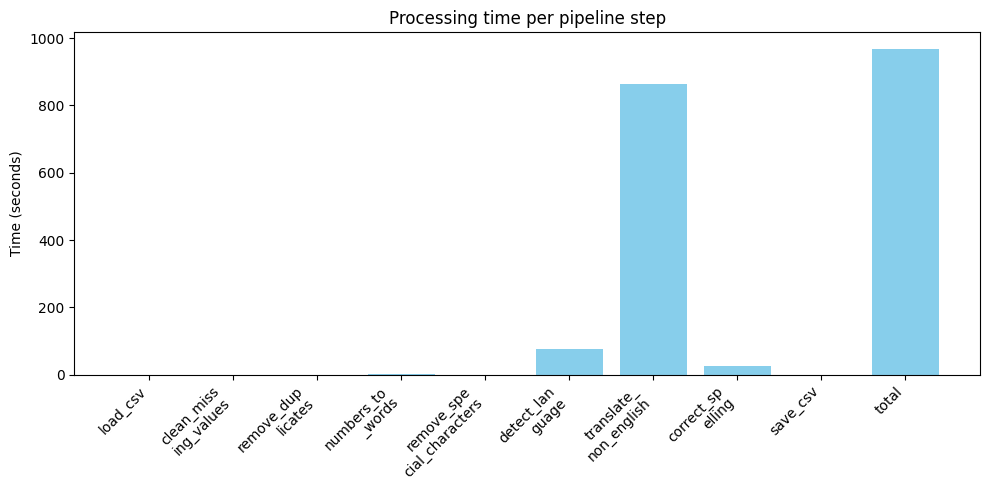

In [60]:
import matplotlib.pyplot as plt

# Définir un max de caractères par ligne
max_chars = 10

# Ajouter un \n si le label dépasse max_chars
labels = [k if len(k) <= max_chars else k[:max_chars] + "\n" + k[max_chars:] for k in timings.keys()]
values = [v for v in timings.values()]

plt.figure(figsize=(10,5))
plt.bar(labels, values, color='skyblue')
plt.ylabel("Time (seconds)")
plt.title("Processing time per pipeline step")
plt.xticks(rotation=45, ha='right')  # Alignement à droite pour lisibilité
plt.tight_layout()  # Ajuste automatiquement les marges
plt.show()
